## 0. Install Dependencies

Run this cell once to ensure all required packages are available in the current kernel.

In [2]:
# Install dependencies (run once per kernel)
import subprocess, sys
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q',
    'boto3', 's3fs', 'pandas', 'numpy', 'matplotlib', 'seaborn',
    'scikit-learn', 'xgboost', 'lightgbm', 'sagemaker', 'pyyaml'])


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


0

# Hyperparameter Tuning - Fraud Detection Model

This notebook demonstrates hyperparameter tuning strategies for the fraud detection
model using the project's `HyperparameterTuner` and `ExperimentTracker` classes.

We cover three approaches:
1. **Grid Search** — exhaustive search over a discrete parameter grid
2. **Random Search** — sampling from parameter distributions (including callable lambdas)
3. **SageMaker Automatic Model Tuning** — Bayesian optimization via managed tuning jobs

All trials are automatically logged to the ExperimentTracker for reproducibility.

**Requirements covered:** 3.1 (Grid search), 3.2 (Random search), 3.3 (SageMaker Automatic Model Tuning), 3.4 (Log all parameter combinations and metrics)

## 1. Setup and Imports

In [3]:
import sys
import io
import random

import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

# Add project src to path
sys.path.insert(0, '../src')
from experiment_tracking import ExperimentTracker
from hyperparameter_tuning import HyperparameterTuner

sns.set_theme(style='whitegrid')
%matplotlib inline

## 2. Load Data from S3

Load the fraud detection dataset from the `fraud-detection-data-<suffix>` bucket and prepare
train/test splits for tuning experiments.

In [4]:
import os
BUCKET_SUFFIX = os.environ.get('BUCKET_SUFFIX', 'quannh0308-20260222')
BUCKET_NAME = f'fraud-detection-data-{BUCKET_SUFFIX}'
DATA_PREFIX = 'prepared'

# Read partitioned Parquet directories directly from S3
train_df = pd.read_parquet(f's3://{BUCKET_NAME}/{DATA_PREFIX}/train.parquet/')
test_df = pd.read_parquet(f's3://{BUCKET_NAME}/{DATA_PREFIX}/test.parquet/')

# Separate features and target
TARGET = 'Class'
FEATURES = [c for c in train_df.columns if c != TARGET]

X_train = train_df[FEATURES]
y_train = train_df[TARGET]
X_test = test_df[FEATURES]
y_test = test_df[TARGET]

print(f'Training set:  {X_train.shape[0]:,} rows, {X_train.shape[1]} features')
print(f'Test set:      {X_test.shape[0]:,} rows, {X_test.shape[1]} features')

Training set:  199,824 rows, 30 features
Test set:      42,337 rows, 30 features


## 3. Initialize ExperimentTracker and HyperparameterTuner

The `HyperparameterTuner` accepts an optional `ExperimentTracker` instance.
When provided, every trial is automatically logged with its parameters and metrics
(Requirement 3.4).

In [5]:
tracker = ExperimentTracker(region_name='us-east-1')
tuner = HyperparameterTuner(tracker=tracker)

print('ExperimentTracker and HyperparameterTuner initialized.')

ExperimentTracker and HyperparameterTuner initialized.


## 4. Grid Search

Grid search evaluates every combination in the parameter grid. This is thorough but
can be expensive for large grids. Use it when the search space is small and you want
full coverage.

**Requirement 3.1**: Support grid search hyperparameter tuning with configurable parameter ranges

In [6]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'use_label_encoder': [False],
    'eval_metric': ['logloss'],
}

total_combos = 1
for v in param_grid.values():
    total_combos *= len(v)
print(f'Grid search will evaluate {total_combos} parameter combinations.')

Grid search will evaluate 27 parameter combinations.


In [7]:
grid_results = tuner.grid_search(
    model_class=XGBClassifier,
    param_grid=param_grid,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    experiment_name='xgboost-grid-search',
    scoring='accuracy',
)

print(f'Grid search complete — {len(grid_results["all_results"])} trials evaluated.')

/opt/homebrew/lib/python3.11/site-packages/xgboost/training.py:200: UserWarning: [23:16:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/lib/python3.11/site-packages/xgboost/training.py:200: UserWarning: [23:16:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/lib/python3.11/site-packages/xgboost/training.py:200: UserWarning: [23:16:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/lib/python3.11/site-packages/xgboost/training.py:200: UserWarning: [23:16:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fo

Grid search complete — 27 trials evaluated.


### 4.1 Grid Search Results

In [8]:
# Build a results DataFrame for easy inspection
grid_rows = []
for trial in grid_results['all_results']:
    row = {**trial['params'], **trial['metrics'], 'score': trial['score']}
    grid_rows.append(row)

grid_df = pd.DataFrame(grid_rows).sort_values('score', ascending=False)
grid_df.head(10)

,max_depth,learning_rate,n_estimators,use_label_encoder,eval_metric,accuracy,precision,recall,f1,auc_roc,score
26,7,0.2,150,False,logloss,0.999409,0.955224,0.744186,0.836601,0.942561,0.999409
25,7,0.2,100,False,logloss,0.999386,0.941176,0.744186,0.831169,0.940901,0.999386
24,7,0.2,50,False,logloss,0.999386,0.941176,0.744186,0.831169,0.938957,0.999386
14,5,0.1,150,False,logloss,0.999339,0.939394,0.720930,0.815789,0.965516,0.999339
12,5,0.1,50,False,logloss,0.999315,0.938462,0.709302,0.807947,0.959555,0.999315
23,7,0.1,150,False,logloss,0.999315,0.938462,0.709302,0.807947,0.956536,0.999315
22,7,0.1,100,False,logloss,0.999315,0.952381,0.697674,0.805369,0.959636,0.999315
17,5,0.2,150,False,logloss,0.999315,0.925373,0.720930,0.810458,0.928653,0.999315
16,5,0.2,100,False,logloss,0.999315,0.925373,0.720930,0.810458,0.925278,0.999315
13,5,0.1,100,False,logloss,0.999315,0.938462,0.709302,0.807947,0.964485,0.999315


In [9]:
print('=== Best Hyperparameters (Grid Search) ===')
print(f'  Score (accuracy): {grid_results["best_score"]:.4f}')
for param, value in grid_results['best_params'].items():
    print(f'  {param}: {value}')

=== Best Hyperparameters (Grid Search) ===
  Score (accuracy): 0.9994
  max_depth: 7
  learning_rate: 0.2
  n_estimators: 150
  use_label_encoder: False
  eval_metric: logloss


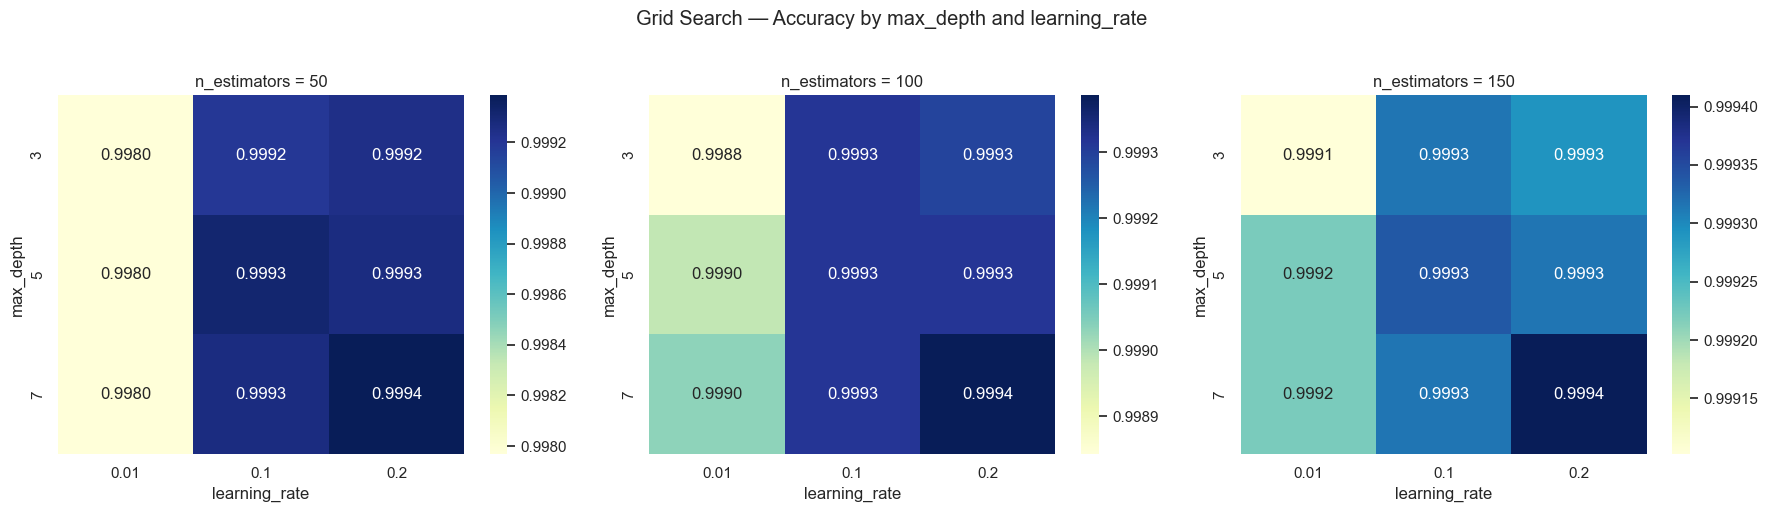

In [10]:
# Visualize grid search: accuracy by max_depth and learning_rate
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, n_est in zip(axes, param_grid['n_estimators']):
    subset = grid_df[grid_df['n_estimators'] == n_est]
    pivot = subset.pivot_table(
        index='max_depth', columns='learning_rate', values='accuracy'
    )
    sns.heatmap(pivot, annot=True, fmt='.4f', cmap='YlGnBu', ax=ax)
    ax.set_title(f'n_estimators = {n_est}')

plt.suptitle('Grid Search — Accuracy by max_depth and learning_rate', y=1.02)
plt.tight_layout()
plt.show()

## 5. Random Search

Random search samples from parameter distributions. It is more efficient than grid
search for high-dimensional spaces because it explores a wider range of values.

Distributions can be:
- **Lists** — a random element is chosen uniformly
- **Callables** (e.g. `lambda: random.uniform(0.01, 0.3)`) — called each iteration

**Requirement 3.2**: Support random search hyperparameter tuning with configurable parameter distributions

In [11]:
param_distributions = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': lambda: random.uniform(0.01, 0.3),
    'n_estimators': lambda: random.randint(50, 200),
    'subsample': lambda: random.uniform(0.5, 1.0),
    'colsample_bytree': lambda: random.uniform(0.5, 1.0),
    'use_label_encoder': [False],
    'eval_metric': ['logloss'],
}

N_ITER = 15
print(f'Random search will sample {N_ITER} parameter combinations.')

Random search will sample 15 parameter combinations.


In [12]:
random_results = tuner.random_search(
    model_class=XGBClassifier,
    param_distributions=param_distributions,
    n_iter=N_ITER,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    experiment_name='xgboost-random-search',
    scoring='accuracy',
)

print(f'Random search complete — {len(random_results["all_results"])} trials evaluated.')

/opt/homebrew/lib/python3.11/site-packages/xgboost/training.py:200: UserWarning: [23:16:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/lib/python3.11/site-packages/xgboost/training.py:200: UserWarning: [23:16:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/lib/python3.11/site-packages/xgboost/training.py:200: UserWarning: [23:16:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/lib/python3.11/site-packages/xgboost/training.py:200: UserWarning: [23:16:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fo

Random search complete — 15 trials evaluated.


### 5.1 Random Search Results

In [13]:
random_rows = []
for trial in random_results['all_results']:
    row = {**trial['params'], **trial['metrics'], 'score': trial['score']}
    random_rows.append(row)

random_df = pd.DataFrame(random_rows).sort_values('score', ascending=False)
random_df.head(10)

,max_depth,learning_rate,n_estimators,subsample,colsample_bytree,use_label_encoder,eval_metric,accuracy,precision,recall,f1,auc_roc,score
7,10,0.269146,189,0.913915,0.504520,False,logloss,0.999480,0.984848,0.755814,0.855263,0.930879,0.999480
1,9,0.212116,54,0.952037,0.952482,False,logloss,0.999457,0.943662,0.779070,0.853503,0.907441,0.999457
9,4,0.133257,121,0.926984,0.645364,False,logloss,0.999457,0.970149,0.755814,0.849673,0.956141,0.999457
11,4,0.113748,199,0.633466,0.724123,False,logloss,0.999457,0.970149,0.755814,0.849673,0.971416,0.999457
0,8,0.119511,129,0.681272,0.984723,False,logloss,0.999433,0.969697,0.744186,0.842105,0.961903,0.999433
8,4,0.138566,188,0.906363,0.734250,False,logloss,0.999409,0.969231,0.732558,0.834437,0.963008,0.999409
2,7,0.179707,125,0.729435,0.632496,False,logloss,0.999386,0.983871,0.709302,0.824324,0.950528,0.999386
6,4,0.098158,190,0.994505,0.628988,False,logloss,0.999386,0.968750,0.720930,0.826667,0.957896,0.999386
14,9,0.271172,148,0.998226,0.582399,False,logloss,0.999386,0.954545,0.732558,0.828947,0.921696,0.999386
5,10,0.101500,185,0.932045,0.991347,False,logloss,0.999362,0.953846,0.720930,0.821192,0.960864,0.999362


In [14]:
print('=== Best Hyperparameters (Random Search) ===')
print(f'  Score (accuracy): {random_results["best_score"]:.4f}')
for param, value in random_results['best_params'].items():
    if isinstance(value, float):
        print(f'  {param}: {value:.4f}')
    else:
        print(f'  {param}: {value}')

=== Best Hyperparameters (Random Search) ===
  Score (accuracy): 0.9995
  max_depth: 10
  learning_rate: 0.2691
  n_estimators: 189
  subsample: 0.9139
  colsample_bytree: 0.5045
  use_label_encoder: False
  eval_metric: logloss


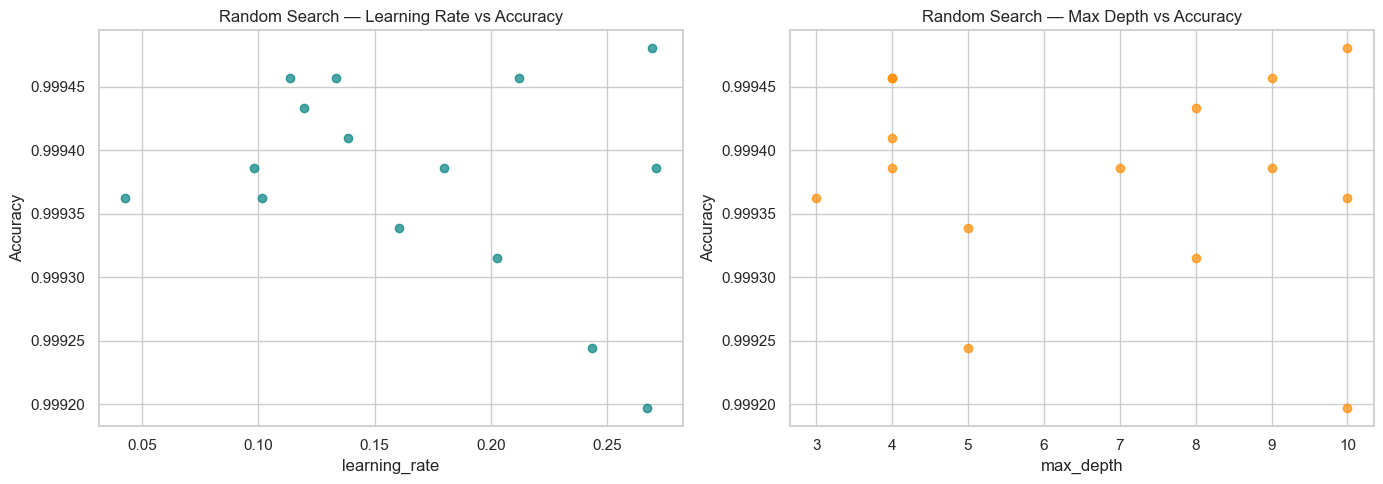

In [15]:
# Visualize random search: scatter of learning_rate vs accuracy
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(random_df['learning_rate'], random_df['accuracy'], c='teal', alpha=0.7)
axes[0].set_xlabel('learning_rate')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Random Search — Learning Rate vs Accuracy')

axes[1].scatter(random_df['max_depth'], random_df['accuracy'], c='darkorange', alpha=0.7)
axes[1].set_xlabel('max_depth')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Random Search — Max Depth vs Accuracy')

plt.tight_layout()
plt.show()

## 6. SageMaker Automatic Model Tuning (Bayesian Optimization)

For large-scale tuning, SageMaker Automatic Model Tuning uses Bayesian optimization
to intelligently explore the hyperparameter space. It runs parallel training jobs on
dedicated instances, making it faster for expensive models.

**Requirement 3.3**: Support Bayesian optimization hyperparameter tuning using SageMaker Automatic Model Tuning

> **Note**: This section requires a SageMaker execution role and S3 training data.
> It will not run in a local-only environment.

In [16]:
import sagemaker
from sagemaker.estimator import Estimator
from sagemaker.tuner import (
    IntegerParameter,
    ContinuousParameter,
    HyperparameterTuner as SageMakerTuner,
)

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_region_name

print(f'SageMaker session region: {region}')
print(f'Execution role: {role}')

ModuleNotFoundError: No module named 'sagemaker.estimator'

In [ ]:
# Configure the XGBoost estimator for SageMaker training
xgb_image_uri = sagemaker.image_uris.retrieve('xgboost', region, version='1.5-1')

xgb_estimator = Estimator(
    image_uri=xgb_image_uri,
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    output_path=f's3://{BUCKET_NAME}/models/tuning-output',
    sagemaker_session=sagemaker_session,
)

# Set static hyperparameters
xgb_estimator.set_hyperparameters(
    objective='binary:logistic',
    eval_metric='auc',
)

print('XGBoost estimator configured.')

In [ ]:
# Define hyperparameter ranges for Bayesian optimization
hyperparameter_ranges = {
    'max_depth': IntegerParameter(3, 10),
    'eta': ContinuousParameter(0.01, 0.3),
    'subsample': ContinuousParameter(0.5, 1.0),
    'colsample_bytree': ContinuousParameter(0.5, 1.0),
    'num_round': IntegerParameter(50, 200),
}

print('Hyperparameter ranges:')
for name, param_range in hyperparameter_ranges.items():
    print(f'  {name}: {param_range}')

In [ ]:
# Launch Bayesian optimization via the project's HyperparameterTuner
TRAIN_DATA_S3 = f's3://{BUCKET_NAME}/{DATA_PREFIX}/train.parquet'
VALIDATION_DATA_S3 = f's3://{BUCKET_NAME}/{DATA_PREFIX}/validation.parquet'

bayesian_results = tuner.bayesian_optimization(
    estimator=xgb_estimator,
    objective_metric_name='validation:auc',
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=20,
    max_parallel_jobs=5,
    train_data_s3=TRAIN_DATA_S3,
    validation_data_s3=VALIDATION_DATA_S3,
)

print(f'Bayesian optimization complete.')
print(f'  Best training job: {bayesian_results["best_training_job"]}')
print(f'  Tuning job name:   {bayesian_results["tuning_job_name"]}')

### 6.1 Retrieve Best Hyperparameters from SageMaker Tuning

In [ ]:
print('=== Best Hyperparameters (SageMaker Bayesian Optimization) ===')
for param, value in bayesian_results['best_params'].items():
    print(f'  {param}: {value}')

## 7. Compare Tuning Methods

Retrieve the best hyperparameters from each method side by side to decide which
configuration to promote to production.

In [17]:
comparison = {
    'Grid Search': {
        'best_score': grid_results['best_score'],
        'best_params': grid_results['best_params'],
        'trials': len(grid_results['all_results']),
    },
    'Random Search': {
        'best_score': random_results['best_score'],
        'best_params': random_results['best_params'],
        'trials': len(random_results['all_results']),
    },
}

print(f'{"Method":<20} {"Best Score":<15} {"Trials"}')
print('-' * 50)
for method, info in comparison.items():
    print(f'{method:<20} {info["best_score"]:<15.4f} {info["trials"]}')

# Determine overall winner between local methods
winner = max(comparison, key=lambda m: comparison[m]['best_score'])
print(f'\nBest local method: {winner} (score: {comparison[winner]["best_score"]:.4f})')

Method               Best Score      Trials
--------------------------------------------------
Grid Search          0.9994          27
Random Search        0.9995          15

Best local method: Random Search (score: 0.9995)


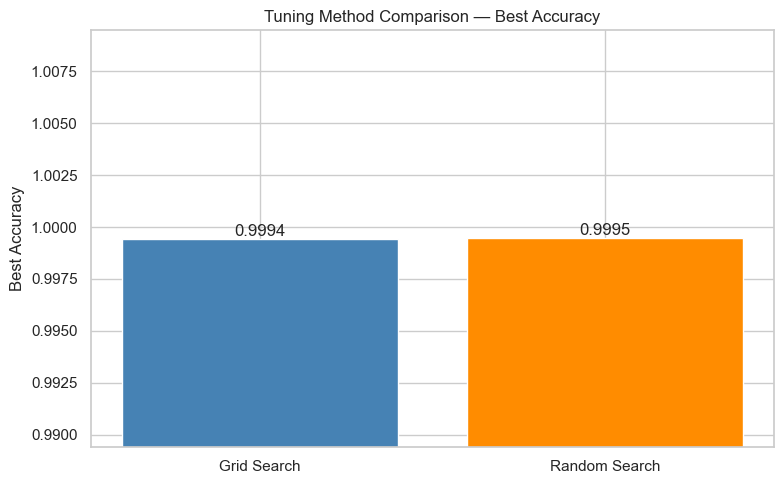

In [18]:
# Bar chart comparing best scores
methods = list(comparison.keys())
scores = [comparison[m]['best_score'] for m in methods]

plt.figure(figsize=(8, 5))
bars = plt.bar(methods, scores, color=['steelblue', 'darkorange'])
plt.ylabel('Best Accuracy')
plt.title('Tuning Method Comparison — Best Accuracy')
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{score:.4f}', ha='center', va='bottom')
plt.ylim(min(scores) - 0.01, max(scores) + 0.01)
plt.tight_layout()
plt.show()

## 8. Query Experiment History

Use the ExperimentTracker to retrieve logged experiments and inspect past tuning runs.

**Requirement 3.4**: Log all parameter combinations and their performance metrics

In [19]:
# Query all grid search experiments
grid_experiments = tracker.query_experiments(
    experiment_name='xgboost-grid-search'
)

print(f'Found {len(grid_experiments)} grid search experiments in tracker.')
if grid_experiments:
    print(f'Sample experiment keys: {list(grid_experiments[0].keys())}')

ModuleNotFoundError: No module named 'sagemaker.experiments'

In [20]:
# Query random search experiments
random_experiments = tracker.query_experiments(
    experiment_name='xgboost-random-search'
)

print(f'Found {len(random_experiments)} random search experiments in tracker.')

ModuleNotFoundError: No module named 'sagemaker.experiments'

## Summary

This notebook demonstrated three hyperparameter tuning strategies:

1. **Grid Search** — exhaustive evaluation of all parameter combinations, best for small search spaces.
2. **Random Search** — efficient sampling with callable distributions (lambdas), better for high-dimensional spaces.
3. **SageMaker Automatic Model Tuning** — Bayesian optimization with parallel training jobs for large-scale tuning.

All trials were logged to the ExperimentTracker for full reproducibility. The best
hyperparameters from any method can be promoted to production using the
`ProductionIntegrator` (see notebook 05).

Next steps: compare algorithms (notebook 03) or promote the winning configuration to production (notebook 05).

## Save Best Results

Save the best hyperparameters to `experiment_results.json` for use in notebook 05 (production promotion).

In [22]:
import json
from datetime import datetime
from pathlib import Path

results_path = Path('../experiment_results.json')

# Load existing results or create new
if results_path.exists():
    with open(results_path) as f:
        all_results = json.load(f)
else:
    all_results = {}

# Save best hyperparameters from grid search
# Map sklearn param names to XGBoost production param names
best = grid_results['best_params']
all_results['hyperparameter_tuning'] = {
    'best_params': {
        'objective': 'binary:logistic',
        'num_round': best.get('n_estimators', 150),
        'max_depth': best.get('max_depth', 7),
        'eta': best.get('learning_rate', 0.15),
        'subsample': best.get('subsample', 0.8),
        'colsample_bytree': best.get('colsample_bytree', 0.8),
    },
    'best_score': grid_results['best_score'],
    'method': 'grid_search',
    'timestamp': datetime.now().isoformat(),
}

with open(results_path, 'w') as f:
    json.dump(all_results, f, indent=2)

print(f'Saved best hyperparameters to {results_path}')
print(json.dumps(all_results['hyperparameter_tuning'], indent=2))

Saved best hyperparameters to ../experiment_results.json
{
  "best_params": {
    "objective": "binary:logistic",
    "num_round": 150,
    "max_depth": 7,
    "eta": 0.2,
    "subsample": 0.8,
    "colsample_bytree": 0.8
  },
  "best_score": 0.99940949996457,
  "method": "grid_search",
  "timestamp": "2026-02-22T23:20:06.223865"
}
